# Wavelet decomposition
In this notebook we will have a bird's eye view on the wavelet manipulation and decomposition.

To ease functions maniplation and understanding, this notebook employs global variables in most of the cases.
It is therefore adviced to pay specific attention to function definitions if modifications have to be made.

Let us start with a wavelet family, which will be the basis for the following tutorial.

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
family='sym8'
wavelet=pywt.Wavelet(family)

# Function decomposition and wavelet analysis

Let's express a function in wavelet. Take the collocation of a one-dimensional gaussian.

In [2]:
def f(x,r0,sigma):
    return 1.0/(sigma*np.sqrt(2.0*np.pi))*np.exp(-0.5/sigma**2*(x-r0)**2)
def f2(x,r0,sigma): #second derivative of a Gaussian
    return 2.0*np.pi*(x**2 - sigma**2)/sigma**4 * f(x,r0,sigma)

Define the value of the x components

In [3]:
L=20
nsteps=2048
h=2*L/nsteps

In [4]:
x=np.arange(-L+h,L+h,step=h)
fx=f(x,0,1.0)
f2x=f2(x,0,1.0)

Original function (second derivative included)

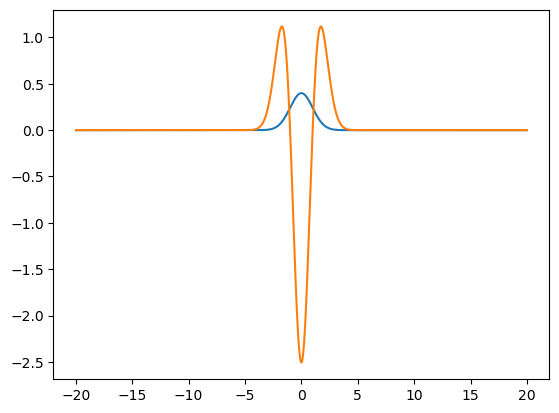

In [5]:
plt.plot(x,fx)
plt.plot(x,f2x)

In [6]:
sum(fx*h) #normalized

0.9999999999999996

Let's see which is the maximum value of the wavelet transfomr that can be applied

In [7]:
max_level=pywt.dwt_max_level(len(x),wavelet)
print(max_level)

7


We cannot perform a wavelet transform with a level higher than this for the above data.
Let's perform a wavelet transform of this signal

In [8]:
decomposition=pywt.wavedec(fx,level=max_level,mode='per',wavelet=wavelet)
decomposition2=pywt.wavedec(f2x,level=max_level,mode='per',wavelet=wavelet) # for future reference

In [9]:
len(decomposition)

8

This decomposition gives rise to a set of coefficients ordered as follows:
 1. Scaling function coefficients at the coarser level
 2. Wavelets at the coarser level
 3. Wavelets at the following levels up to `max_level`
 
We the have a set of coefficients of length `max_level` + 1. 
Each level corresponds to a central position of the basis function centered on a grid of spacing $h \cdot 2^{(M-\ell)}$ where $M$ is `max_level` and $\ell$ is the resolution level, starting from 0 at the coarser one.

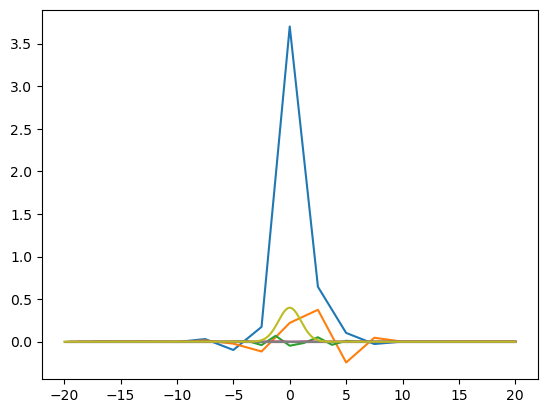

In [10]:
for ell in range(max_level):
    newh=h*2**(max_level-ell)
    xl=np.arange(-L+newh,L+newh,step=newh)
    if ell == 0:
        plt.plot(xl,decomposition[ell]) #the scaling functions
    plt.plot(xl,decomposition[ell+1]) # the details in wavelets
plt.plot(x,fx) # the original function

From those coefficients the original function can be rebuilt.
Of course, neglecting some details, will reconstructu only a portion of the initial function

In [11]:
rebuilt=pywt.waverec(decomposition,mode='per',wavelet=wavelet)

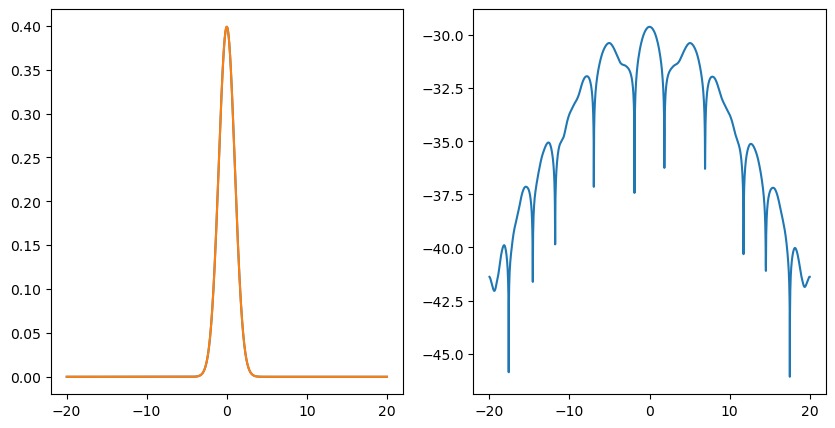

In [12]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x,fx)
ax[0].plot(x,rebuilt)
ax[1].plot(x,np.log(abs(fx-rebuilt)))

Neglecting some coefficients of the wavelets would provide an approximated function

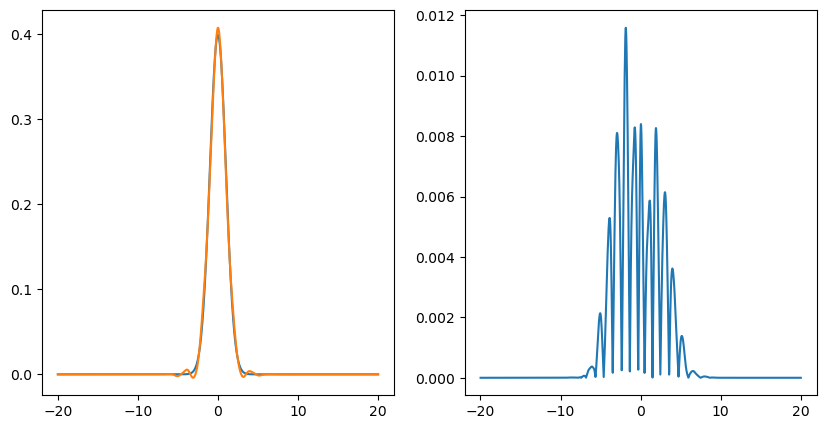

In [13]:
top_level=2
newd=decomposition.copy()
for ell in range(top_level,len(newd)):
    n=len(newd[ell])
    newd[ell]=np.zeros(n)
rebuilt=pywt.waverec(newd,mode='per',wavelet=wavelet)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x,fx)
ax[0].plot(x,rebuilt)
ax[1].plot(x,abs(fx-rebuilt))

Here the function is so smooth that the approximation error is barely visible even in the case of just scaling functions.
As an exercise you may play with the function smoothness and the grid spacing to verify the effect of a good/bad approximation.
You can also alter the value of `top_level` to see what's happening.

# Plot a single basis function

The easiest way to generate wavelet and scaling function plots is based on
backward wavelet transforms. To generate the scaling function we start with
a data set where all the wavelet d coefficients on all resolution levels are zero
and where only one scaling function s coefficient is nonzero, i.e. $s_0 = 1$.
In the case of the wavelet only one d coefficient is nonzero, i.e. $d_0 = 1$. By
doing repeated backward transform sweeps, we express these two functions
by skinnier and skinnier scaling functions. Since the wavelet and scaling
functions have in general certain smoothness properties, they will be nearly
constant within a very small interval and neighboring coefficients at very high
resolution levels will vary very little. The average over very small intervals
will thus be proportional to the s coefficients at sufficiently high resolution.

In [14]:
singlefun=pywt.wavedec(np.zeros(nsteps),level=max_level,mode='per',wavelet=wavelet) # to create a set of zero coefficients
data=singlefun[0] #the interesting resolution (put 1 for wavelet)
n=len(data)
data[round(n/2)-1] = 1.0 # to put the function at the box center
phi=pywt.waverec(singlefun,mode='per',wavelet=wavelet)/np.sqrt(2)**max_level # to restore the normalization

The x coordinate of the wavelet can be inferred from the extension of the filter coefficients.
We will show in the following that this procedure provides the correct interpretation of the results

In [15]:
Lw=wavelet.dec_len
O=round(Lw/2)
L1=-O
L2=L1+Lw
indexes=list(range(L1+1,L2+1))
hw=Lw/nsteps
t=-np.arange(L1+hw,L2+hw,step=hw)

In [16]:
indexes

[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

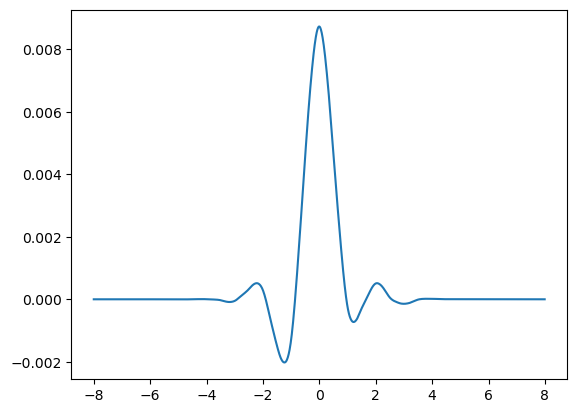

In [17]:
plt.plot(t,phi)

This function has compact support, and it is strictly zero outside it:

/tmp/ipykernel_29756/2300695292.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(t,np.log(abs(phi)))


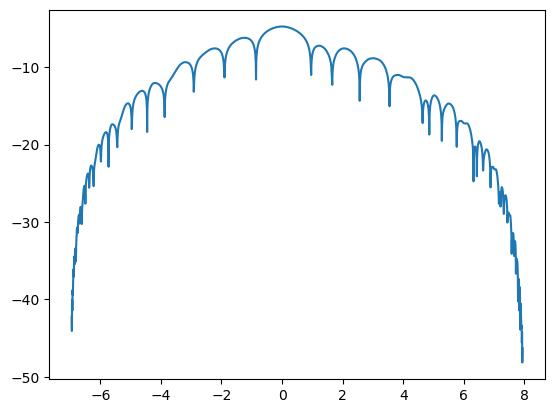

In [18]:
plt.plot(t,np.log(abs(phi)))

We can plot the wavelet function with the same technique

In [19]:
singlefun=pywt.wavedec(np.zeros(nsteps),level=max_level,mode='per',wavelet=wavelet) # to create a set of zero coefficients
data=singlefun[1]
n=len(data)
data[int(n/2)-1] = 1.0 # to put the function at the box center
psi=pywt.waverec(singlefun,mode='per',wavelet=wavelet)/np.sqrt(2)**max_level # to restore the normalization

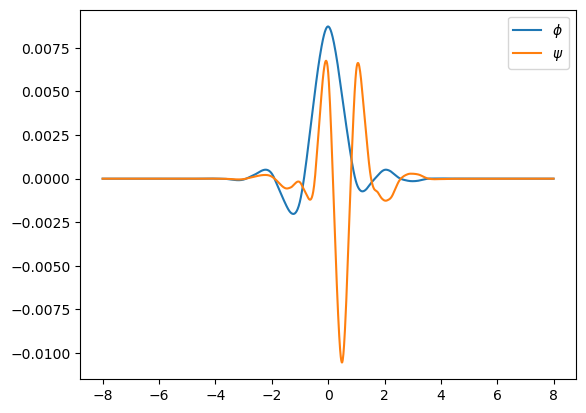

In [20]:
plt.plot(t,phi,label=r'$\phi$')
plt.plot(t,psi,label=r'$\psi$')
plt.legend(loc='best')

For the wavelet family `sym8` those functions are the basis set employed in the BigDFT code to represent the Kohn Sham orbitals (as a tensor product decomposition)

For comparison with the future calculations, we can define a function which would enable to visualize the basis decompositions

In [21]:
def phi_fun(x):
    if x in t:
        return phi[list(t).index(x)]
    else:
        if x >= min(t) and x <= max(t):
            raise ValueError('Grid spacing not compatible',x)
        return 0.0

Let's verify the recursion relation between scaling functions:
$$
\phi(x) = \sum_\mu h_\mu \phi(2*x - \mu)
$$

In [22]:
new_phi_fun=np.zeros(len(t))
for i,xx in enumerate(t):
    newphi=0
    for hm,mu in zip(wavelet.dec_lo,indexes):
        newphi+=np.sqrt(2)*hm * phi_fun(2*xx-mu)
    new_phi_fun[i]=newphi

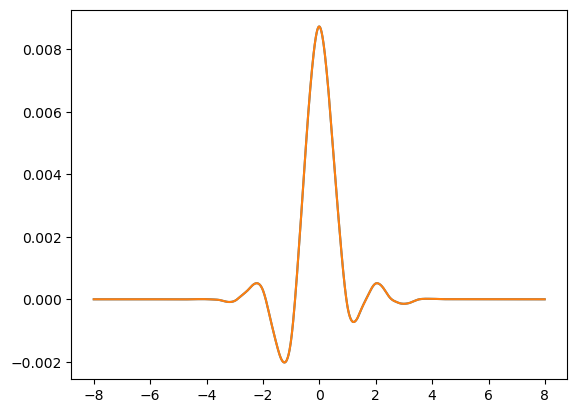

In [23]:
plt.plot(t,new_phi_fun)
plt.plot(t,phi)

The demonstration above shows that the actual wavelet filter coefficients are (for a orthogonal family) multiplied by $\sqrt 2$.
The `indexes` array enables us to identify the index $\mu$ associated to each of the filters $h_\mu$ .

# Expansion of polynomials and moments of the scaling functions
The moments of the scaling functions can be easily calculated from the refinement relation:
$$
M_\ell \equiv \int dx \phi(x)x^\ell = \sum_\mu h_\mu \int dx \phi(2x-\mu) x^\ell =\frac{1}{2^{\ell+1}} \sum_\mu h_\mu \int dx \phi(x) \left(x+\mu\right)^\ell 
=\frac{1}{2^{\ell+1}}  \sum_{p=0}^\ell \binom{\ell}{p} \sum_\mu h_\mu\mu^{\ell-p} \int dx \phi(x) x^p = \frac{1}{2^{\ell+1}}  \sum_{p=0}^\ell \binom{\ell}{p} H_{\ell-p} M_p
$$
where we have introduced $H_q\equiv \sum_\mu h_\mu\mu^{q}$. Knowing that $M_0=1$, the other moments can be calculated by recursion.
Indeed, from the above equation we have:
$$
M_\ell  = \frac{1}{2^{\ell+1} - H_{0}}  \sum_{p=0}^{\ell-1} \binom{\ell}{p} H_{\ell-p} M_p 
$$

In our family, $H_0=2$:

In [24]:
np.sqrt(2)*sum(wavelet.rec_lo)

2.0000000000000004

Therefore $$M_\ell  = \frac{1}{2^{\ell+1}-2}  \sum_{p=0}^{\ell-1} \binom{\ell}{p} H_{\ell-p} M_p$$

In [25]:
def H(q):
    h=wavelet.dec_lo
    return sum(np.sqrt(2)*hm*mu**q for hm,mu in zip(h,indexes))

In [26]:
def M(ell,moments):
    assert len(moments) == ell
    from scipy.special import binom
    mom=sum(binom(ell,p) * H(ell-p) *moments[p] for p,m in enumerate(moments))
    return mom/(2**(ell+1) -2)
        

The moments of the scaling function can then be calculated as follows

In [27]:
def all_moments(ell):
    allmom=[1.0]
    for p in range(1,ell):
        allmom.append(M(p,allmom))
    return allmom

And compared with the moments calculated explicitly:

In [28]:
[sum(f*(tx+hw)**i for f,tx in zip(phi,t)) for i in range(8)]

[0.9999999999999982,
 0.16697723763078237,
 0.027881397887134344,
 0.12277643010775047,
 0.07967135953730248,
 -0.3067534930602034,
 -0.18990482067719489,
 6.757784746522602]

In [29]:
[m for m in all_moments(8)]

[1.0,
 0.1604180032814184,
 0.025733935777124725,
 0.12224911422565411,
 0.0764571288757426,
 -0.3093136485295334,
 -0.17778155069857998,
 6.766226379687443]

# The Magic Filter procedure
The collocation of a function can become quite difficult in wavelet basis. There are two main reasons.
One is that the wavelet function are quite cumbersome to be expressed in real space, an the second is their smoothness properties.
The Magic filter procedure enables to express a efficient passage matrix between the coefficients of a function expressed in wavelets and their collocation values in a real-space grid. Such a passage matrix preserves the moments of the original function up to the order of the wavelet family. 

In [30]:
order=8
vdm=np.zeros([2*order,2*order])
for i,j in enumerate(range(1-order,order+1)):
    for p in range(2*order):
        vdm[p][i]=(j)**p

In [31]:
w=np.linalg.solve(vdm,all_moments(2*order))

In [32]:
w

array([ 2.72734493e-06, -5.18598688e-05,  4.94432277e-04, -3.44128144e-03,
        1.33726341e-02, -2.10302516e-02, -6.04895289e-02,  9.94041570e-01,
        6.12625896e-02,  2.37382146e-02, -9.42047030e-03,  1.74723714e-03,
       -3.01580381e-04,  8.76298448e-05, -1.29055720e-05,  8.43342473e-07])

## Passage matrix

In [33]:
newh=h*2**(max_level)
xl=np.arange(-L+newh,L+newh,step=newh)

In [34]:
decomposition[0]

array([ 1.43981911e-09,  2.55880170e-06, -6.43184707e-05, -3.82277060e-03,
        3.07696590e-02, -9.75752250e-02,  1.73434186e-01,  3.70111075e+00,
        6.44483351e-01,  1.02896510e-01, -2.74367209e-02,  1.08683202e-03,
        6.12615493e-04, -1.44018017e-05,  3.68013296e-07,  6.09883958e-11])

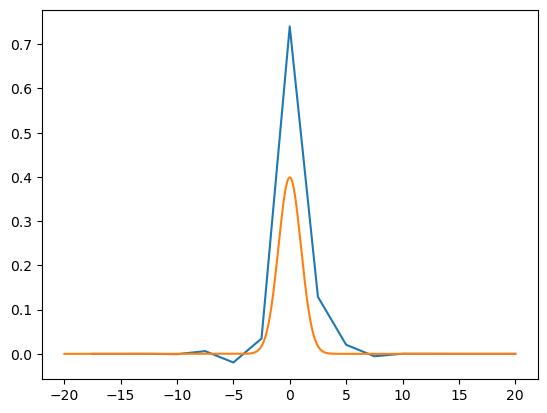

In [35]:
plt.plot(xl,decomposition[0]/5.0)
plt.plot(x,fx)

We want to apply the magic filter convolution to the scaling function coeffcients of the previous function representation
$$
\tilde f_i \equiv \sum_j w_{i-j} s_{j} = \sum_j w_{j} s_{j+i}
$$

In [36]:
def convolve(data,filt,indexes):
    N = len(data)
    result=np.zeros(N)
    for i in range(N):
        r=0
        for j,f in zip(indexes,filt):
            k = (i+j) % N #periodically wrap index if necessary
            r += f*data[k]
        result[i]=r
    return result

In [37]:
mf_f=convolve(decomposition[0],w,indexes)

In [38]:
h

0.01953125

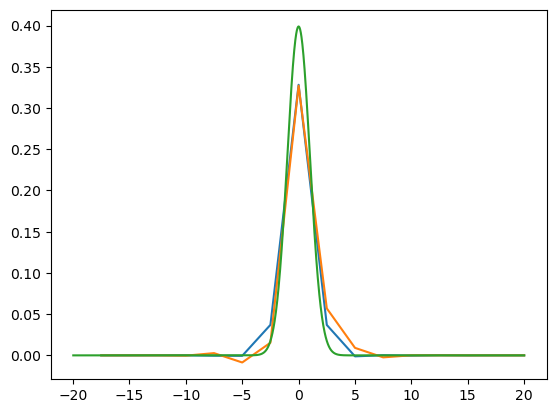

In [39]:
plt.plot(xl,mf_f/np.sqrt(2)**max_level)
plt.plot(xl,decomposition[0]/np.sqrt(2)**max_level)
plt.plot(x,fx)

In [40]:
# the magic filter preserves the moments
sum(mf_f/np.sqrt(2)**max_level*5/2),sum(decomposition[0]/np.sqrt(2)**max_level*5/2)

(1.000000000000492, 1.0000000000000888)

# The second derivative of a function

In [41]:
K1=L1-L2+2
K2=L2-L1-1
kinrange=list(range(K1,K2))
print(kinrange)
def kinetic_matrix():
    h=wavelet.dec_lo
    M=len(kinrange)
    A=np.zeros([M,M])
    for ii,i in enumerate(range(K1,K2)):
        for jj,j in enumerate(range(K1,K2)):
            aij=0
            for mu,hm in zip(indexes,h):
                for nu,hn in zip(indexes,h):
                    if 2*i - nu + mu == j:
                        #print(i,j,nu,mu)
                        aij += hm*hn
            A[ii][jj]= aij
    return A

[-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [42]:
A=kinetic_matrix()

/tmp/ipykernel_29756/209938166.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(A)))


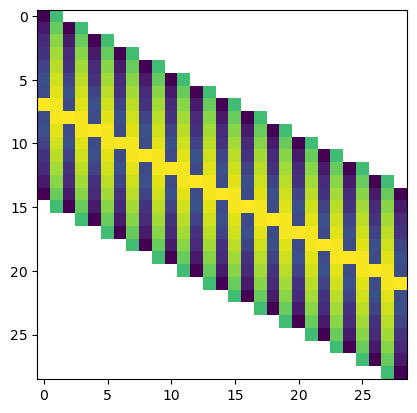

In [43]:
plt.imshow(np.log(abs(A)))

In [44]:
E,V=np.linalg.eig(A)

In [45]:
E

array([ 1.00000000e+00,  5.00000000e-01,  2.50000000e-01,  1.25000000e-01,
        6.25000000e-02,  3.12500000e-02, -1.70552568e-02,  1.75858228e-02,
        1.56250000e-02, -9.46298500e-03,  7.89430385e-03,  7.81250000e-03,
        5.21922612e-03,  3.90624999e-03, -3.20756594e-03, -2.51114427e-03,
        1.95312500e-03,  1.08872559e-03,  9.76562457e-04,  9.45193067e-04,
        4.88281251e-04, -2.94905215e-04, -2.72174786e-04,  2.44140624e-04,
        1.22070312e-04,  3.05175781e-05,  6.10351562e-05,  5.60253497e-05,
        5.80380721e-05])

In [46]:
a=V.T[2]

In [47]:
a

array([ 1.43244744e-18, -5.60254663e-14,  1.20282398e-11,  2.19005911e-09,
        7.70261099e-08, -4.32484260e-07,  4.96165533e-06, -9.34471633e-05,
        8.47757458e-04, -4.56608619e-03,  1.70199594e-02, -4.90693762e-02,
        1.27363393e-01, -4.59115569e-01,  7.35217521e-01, -4.59115569e-01,
        1.27363393e-01, -4.90693762e-02,  1.70199594e-02, -4.56608619e-03,
        8.47757458e-04, -9.34471633e-05,  4.96165533e-06, -4.32484260e-07,
        7.70261099e-08,  2.19005911e-09,  1.20282398e-11, -5.60254663e-14,
        1.43259317e-18])

In [48]:
norm=0
for i,aa in zip(kinrange,a):
    norm += i**2 * aa
a *= 2/norm

In [49]:
a

array([-6.92377055e-18,  2.70800494e-13, -5.81387983e-11, -1.05857055e-08,
       -3.72307630e-07,  2.09042350e-06, -2.39822852e-05,  4.51679203e-04,
       -4.09765689e-03,  2.20702919e-02, -8.22664000e-02,  2.37178058e-01,
       -6.15614147e-01,  2.21914659e+00, -3.55369229e+00,  2.21914659e+00,
       -6.15614147e-01,  2.37178058e-01, -8.22664000e-02,  2.20702919e-02,
       -4.09765689e-03,  4.51679203e-04, -2.39822852e-05,  2.09042350e-06,
       -3.72307630e-07, -1.05857055e-08, -5.81387983e-11,  2.70800494e-13,
       -6.92447494e-18])

Convolution with second derivative.

In [50]:
d2_f=convolve(decomposition[0],a,kinrange)

In [51]:
newh

2.5

In [54]:
sum(abs(d2_f))/sum(abs(decomposition2[0]))

0.9998092807207419

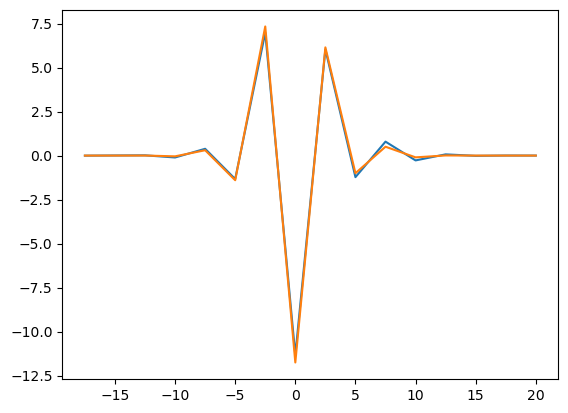

In [55]:
plt.plot(xl,d2_f)
plt.plot(xl,decomposition2[0])

# Useless material, to be erased

In [ ]:
#wvl2=pywt.wavedec(datasampleL[1],'db4',level=4)
wvl2=pywt.wavedec(datatest[1],'db4',level=4)
plt.plot(wvl2[0])
plt.plot(wvl2[1])

In [ ]:
import scipy.interpolate as ipl

Choose the set of data that will be used for the interpolation

In [ ]:
start=20
end=22 #30
xval=range(start,end)
x=np.array(range(5,9)+xval)
y=wvl2[0][x]
f=ipl.splrep(x,y,k=2,s=0) #4

%matplotlib auto
plt.plot(wvl2[0])
x2=range(np.min(x),np.max(x)+1)
y2=ipl.splev(x2,f)
plt.plot(x2,y2)
#plt.xlim([prestart,len(wvl2[0])])
#plt.ylim(auto=True)

Once the chosen interpolation has been validated we might substitute its values in the original data

In [ ]:
wvl2[0][x2]=y2
rebuild=pywt.waverec(wvl2,'db4')
plt.loglog(datatest[0],rebuild)
#plt.loglog(datasampleH[0],datasampleH[1])

In [ ]:
class Datasignal():
    def __init__(self,filename):
        import numpy
        self.data=numpy.loadtxt(filename).T
        self.decompose(level=4)
        self.recompose()
    def decompose(self,level,family='db4'):
        import pywt
        self.decomposition=pywt.wavedec(self.data[1],family,level=level)
        self.family=family
        self.reinterpretation=None
    def recompose(self):
        import pywt
        if self.reinterpretation is not None:
            d=self.reinterpretation
            self.decomposition[0][d['xtot']]=d['y']
        self.recomposition=pywt.waverec(self.decomposition,self.family)
    def plot(self,quantity='recomposed',logy=False,loglog=False):
        import matplotlib.pyplot as plt
        plscheme=plt.plot
        if logy: plscheme=plt.semilogy
        if loglog: plscheme=plt.loglog            
        if quantity=='original':
            plscheme(self.data[0],self.data[1])
            if self.reinterpretation is not None:
                plscheme(self.data[0],self.recomposition)
        elif quantity=='recomposed':
            plscheme(self.data[0],self.recomposition)
        elif quantity=='lowres':
            plscheme(self.decomposition[0])
            if self.reinterpretation is not None:
                plscheme(self.reinterpretation['xtot'],self.reinterpretation['y'])
        plt.show()
    def interpolate(self,anchors,k=3,s=0):
        import scipy.interpolate as ipl
        import numpy
        d={}
        d['anchors']=numpy.array(anchors)
        d['xtot']=numpy.array(range(numpy.min(d['anchors']),numpy.max(d['anchors'])+1))
        y=self.decomposition[0][d['anchors']]
        f=ipl.splrep(d['anchors'],y,k=k,s=s) #4
        d['y']=ipl.splev(d['xtot'],f)
        self.reinterpretation=d
        self.plot('lowres')
        self.recompose()
        
    

In [ ]:
FS=Datasignal('D16_Sample1253K.dat')

In [ ]:
FS.plot(loglog=True)

In [ ]:
%matplotlib inline
FS.decompose(5)
FS.plot('lowres')

In [ ]:
start=20
end=22 #30
xval=range(start,end)
x=np.array(range(5,9)+xval)

In [ ]:
FS.interpolate(x,k=2,s=0)

In [ ]:
FS.plot('original',loglog=True)

In [ ]:
buffer1=Datasignal('D16_Phosphate253K.dat')

In [ ]:
buffer1.decompose(5)
buffer1.plot('lowres')

In [ ]:
FS.decompose(5)
buffer1.decompose(5)
xtest=[6,12,14,15,16]
buffer1.interpolate(xtest,k=1,s=0)
FS.interpolate(xtest,k=2)

In [ ]:
buffer1.plot('original',loglog=True)
FS.plot('original',loglog=True)
buffer1.plot(loglog=True)
FS.plot(loglog=True)

In [ ]:
buffer2=Datasignal('D16_Succinate253K.dat')
buffer2.plot(loglog=True)

In [ ]:
buffer2.decompose(5)
buffer2.interpolate(xtest,k=1,s=0)
buffer2.plot('original',loglog=True)
buffer2.plot(loglog=True)